# Importaciones

In [1]:
from imports import *                    # pandas, numpy, etc.
from trading_environment import (
    DataManager,
    Optimizer,
    PerformanceAnalyzer,
    ReportManager,
    RiskManager,
    DATA_DIR,
    MAX_FILE_SIZE,
    REPORT_DIR
)
from strategies import (
    MovingAverageCrossStrategy,
    DcaStrategy,
    DonchianBreakoutStrategy,
    ADXTrendStrategy,
    ROCStrategy,
    MACDStrategy,
    BollingerMeanRevStrategy,
    RSIStrategy,
    PairTradingStrategy,
    VWAPStrategy
)

# Strategies

2025-06-23 23:50:19,825 - INFO - Cargados 732 registros de caché (1 archivos)



Processing strategy type: MA Cross
MA 5/50              — Best Sharpe 0.6424 with {'short_window': 5, 'long_window': 50}

Processing strategy type: DCA
DCA 500@W            — Best Sharpe 1.3091 with {'amount': 500, 'freq': 'W'}

Processing strategy type: Donchian
Donchian 50          — Best Sharpe 0.9993 with {'window': 50}

Processing strategy type: ADX + MA
ADX + MA             — no valid parameter combos (No valid parameter combinations for ADXTrendStrategy), skipping this strategy type

Processing strategy type: ROC
ROC 20               — Best Sharpe 0.4856 with {'window': 20}

Processing strategy type: MACD
MACD                 — no valid parameter combos (No valid parameter combinations for MACDStrategy), skipping this strategy type

Processing strategy type: BB Mean Reversion
BB Rev 20/1.5        — Best Sharpe -0.0179 with {'window': 20, 'n_std': 1.5}

Processing strategy type: RSI
RSI                  — no valid parameter combos (No valid parameter combinations for RSIStrategy

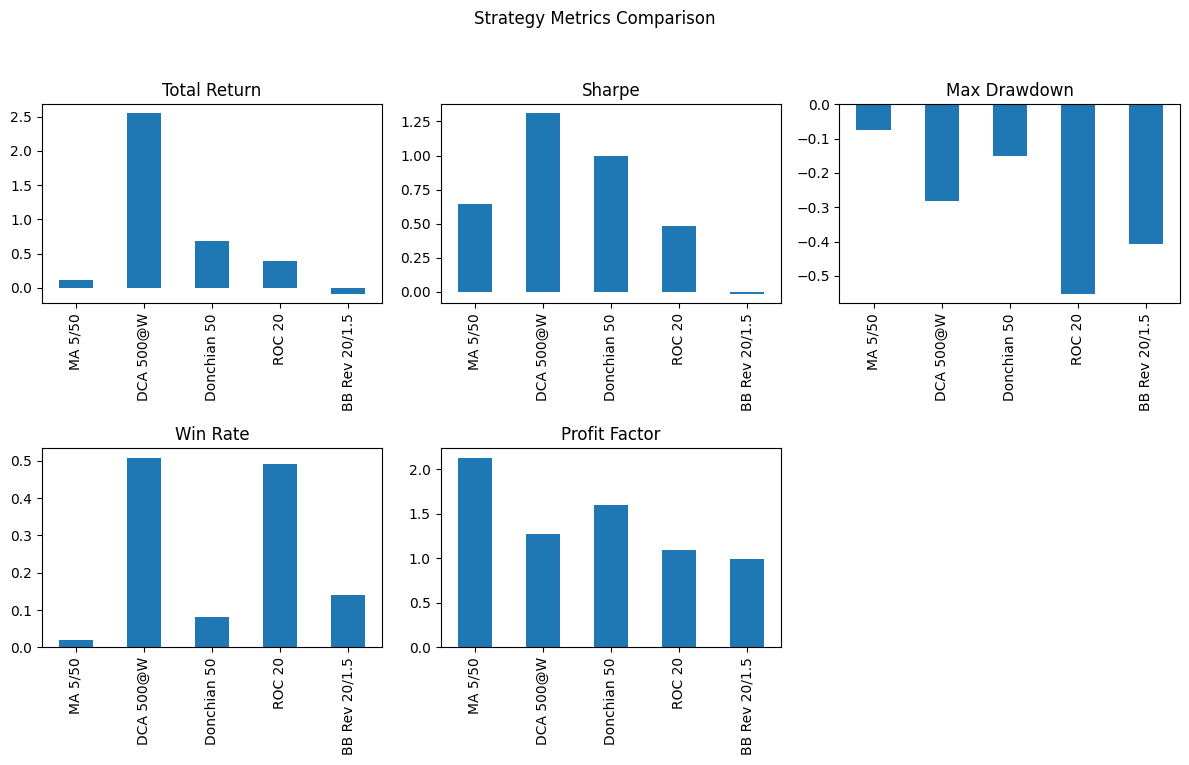

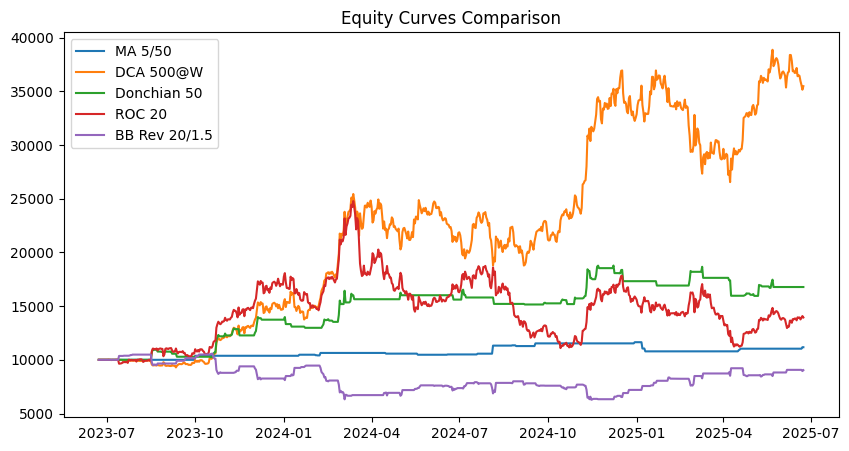

In [2]:
from imports import *
from trading_environment import (
    DataManager,
    Optimizer,
    PerformanceAnalyzer,
    ReportManager,
    DATA_DIR,
    MAX_FILE_SIZE,
    REPORT_DIR
)
from strategies import (
    MovingAverageCrossStrategy,
    DcaStrategy,
    DonchianBreakoutStrategy,
    ADXTrendStrategy,
    ROCStrategy,
    MACDStrategy,
    BollingerMeanRevStrategy,
    RSIStrategy,
    PairTradingStrategy,
    VWAPStrategy
)

# 1) Load data
dm = DataManager(data_dir=DATA_DIR, max_file_size=MAX_FILE_SIZE)
data = dm.load_data(
    symbols='BTC-USD',
    period='2y',
    interval='1d'
)

# 2) Define parameter grids
param_grids = {
    'MA Cross': (
        MovingAverageCrossStrategy,
        {'short_window': [5, 20, 50], 'long_window': [50, 100, 200]}
    ),
    'DCA': (
        DcaStrategy,
        {'amount': [500, 1000, 2000], 'freq': ['D', 'W', 'M']}
    ),
    'Donchian': (
        DonchianBreakoutStrategy,
        {'window': [10, 20, 50]}
    ),
    'ADX + MA': (
        ADXTrendStrategy,
        {'short_w': [5, 20], 'long_w': [50, 100], 'adx_w': [14, 20]}
    ),
    'ROC': (
        ROCStrategy,
        {'window': [5, 10, 20]}
    ),
    'MACD': (
        MACDStrategy,
        {'fast': [8, 12], 'slow': [26, 30], 'signal': [9, 12]}
    ),
    'BB Mean Reversion': (
        BollingerMeanRevStrategy,
        {'window': [10, 20], 'n_std': [1.5, 2, 2.5]}
    ),
    'RSI': (
        RSIStrategy,
        {'window': [10, 14, 20], 'low': [30], 'high': [70]}
    ),
    'Pair Trading': (
        PairTradingStrategy,
        {'pair': [('BTC-USD','ETH-USD')], 'window': [20, 30], 'entry_z': [1.5, 2], 'exit_z': [0, 0.5]}
    ),
    'VWAP': (
        VWAPStrategy,
        {}  # no tunable params
    )
}

best_specs      = {}
best_equities   = {}
best_strategies = {}

# 3) Find the best Sharpe param set for each
for type_name, (cls, grid) in param_grids.items():
    print(f"\nProcessing strategy type: {type_name}")

    # Handle non-tunable strategies
    if not grid:
        try:
            strat = cls()
            eq    = strat.backtest(data)
            sharpe = PerformanceAnalyzer(eq, strat.returns).summary()['Sharpe']
        except Exception as e:
            print(f"{type_name:20s} — all runs failed ({e}), skipping this strategy type")
            continue

        display_name = strat.name
        print(f"{display_name:20s} — no params, raw Sharpe = {sharpe:.4f}")

        best_specs[display_name]      = {}
        best_equities[display_name]   = eq
        best_strategies[display_name] = strat
        continue

    # Tunable strategies: use Optimizer
    opt = Optimizer(cls, grid)

    try:
        strat, eq, results = opt.best_strategy(data, metric='Sharpe')
    except ValueError as e:
        print(f"{type_name:20s} — no valid parameter combos ({e}), skipping this strategy type")
        continue

    if strat is None or eq is None:
        print(f"{type_name:20s} — best_strategy build/backtest failed, skipping this strategy type")
        continue

    params = opt.best_params(results)
    sharpe = results.loc[0, 'Sharpe']
    display_name = strat.name  # includes params!

    print(f"{display_name:20s} — Best Sharpe {sharpe:.4f} with {params}")

    best_specs[display_name]      = params
    best_equities[display_name]   = eq
    best_strategies[display_name] = strat

# 4) If nothing succeeded, bail out
if not best_equities:
    print("No strategy types produced a valid backtest. Exiting.")
    exit()

# 5) Compare all “best” strategies at once, using display_name keys
analyzers = {
    display_name: PerformanceAnalyzer(eq, best_strategies[display_name].returns)
    for display_name, eq in best_equities.items()
}

rep_mgr = ReportManager(directory=REPORT_DIR)
comparison_df = rep_mgr.summarize(
    analyzers,
    save=False,
    do_print=True
)

# 6) And plot
rep_mgr.plot_metrics(comparison_df)
rep_mgr.plot_equity_curves(best_equities)


# FIN